This IPYNB is the machine learning element of Sebastian Usai's Capstone project with WQU.

This notebook will import the EURUSD data, prepare the necessary features, select the features, split and scale the data, fit a gradient boosting classification model and take the predictions back to the original unscaled data to test how the model performed.


In [1]:
#libraries
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
style.use ('ggplot')
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from scipy.stats import skew
from scipy.stats import kurtosis

#Import raw data from Pepperstone
df = pd.read_csv('EURUSD1440.csv', parse_dates = True, index_col=0)

#Rename columns
df=df.rename(columns = {'0.53690':'Open'})
df=df.rename(columns = {'0.53690.1':'High'})
df=df.rename(columns = {'0.53690.2':'Low'})
df=df.rename(columns = {'0.53690.3':'Close'})
df=df.rename(columns = {'1':'Volume'})

In [2]:
#we want to predict log return
df['Log Return'] = np.log(df.Close) - np.log(df.Close.shift(1))
df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))

#Momentum Features
df['R1']= df['Market Return'].rolling(window=10).mean()
df['R2']= df['Market Return'].rolling(window=20).mean()
df['R3']= df['Market Return'].rolling(window=50).mean()
df['R4']= df['Market Return'].rolling(window=100).mean()
df['R5']= df['Market Return'].rolling(window=200).mean()
df['R6']= df['Market Return'].rolling(window=400).mean()

#Moving average for 'trend' feature
df['MA200']=df['Close'].rolling(200).mean()


In [3]:
#Make a binary classification filter showing if the days return was positive or negative

#Create an "empty" column as placeholder for our /position signals

df['Prediction'] = None

#Fill our newly created position column - we will buy (1) for an upper band break and go to 0 on a lower band break
        
for row in range(len(df)):
   
    if df['Log Return'].iloc[row]>0.000:
        df['Prediction'].iloc[row] = 1    
        
    if df['Log Return'].iloc[row]<=0.000:
        df['Prediction'].iloc[row] = 0
        

#Forward fill our prediction column and shit so that we know tomorrows outcome today (So we can train our ML algo knowing the desired outcome)
df['Prediction'].fillna(method='ffill',inplace=True)
df['Prediction']=df['Prediction'].shift(-1)


C:\Users\Seb Usai\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
#Make a binary trend filter based on price compared to the 200 period moving average
df['Trend'] = None
#Fill our newly created trend column 
        
for row in range(len(df)):
   
    if df['Close'].iloc[row]>df['MA200'].iloc[row]:
        df['Trend'].iloc[row] = 1    
        
    if df['Close'].iloc[row]<df['MA200'].iloc[row]:
        df['Trend'].iloc[row] = -1       

#forward through time
df['Trend'].fillna(method='ffill',inplace=True)


In [5]:
#Export to CapstoneML.csv ready for part 2

export_csv = df.to_csv (r'C:\Users\Seb Usai\Anaconda3\AAA WQU CF\Capstone\CapstoneML.csv', index = True, header=True)


In [22]:
#PART 2

#Now lets fit a machine learning model

#Data
df = pd.read_csv('CapstoneML.csv', parse_dates = True, index_col=0)

df3 = df.dropna()

Index(['00:00', 'Open', 'High', 'Low', 'Close', 'Volume', 'Log Return',
       'Market Return', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'MA200',
       'Prediction', 'Trend'],
      dtype='object')

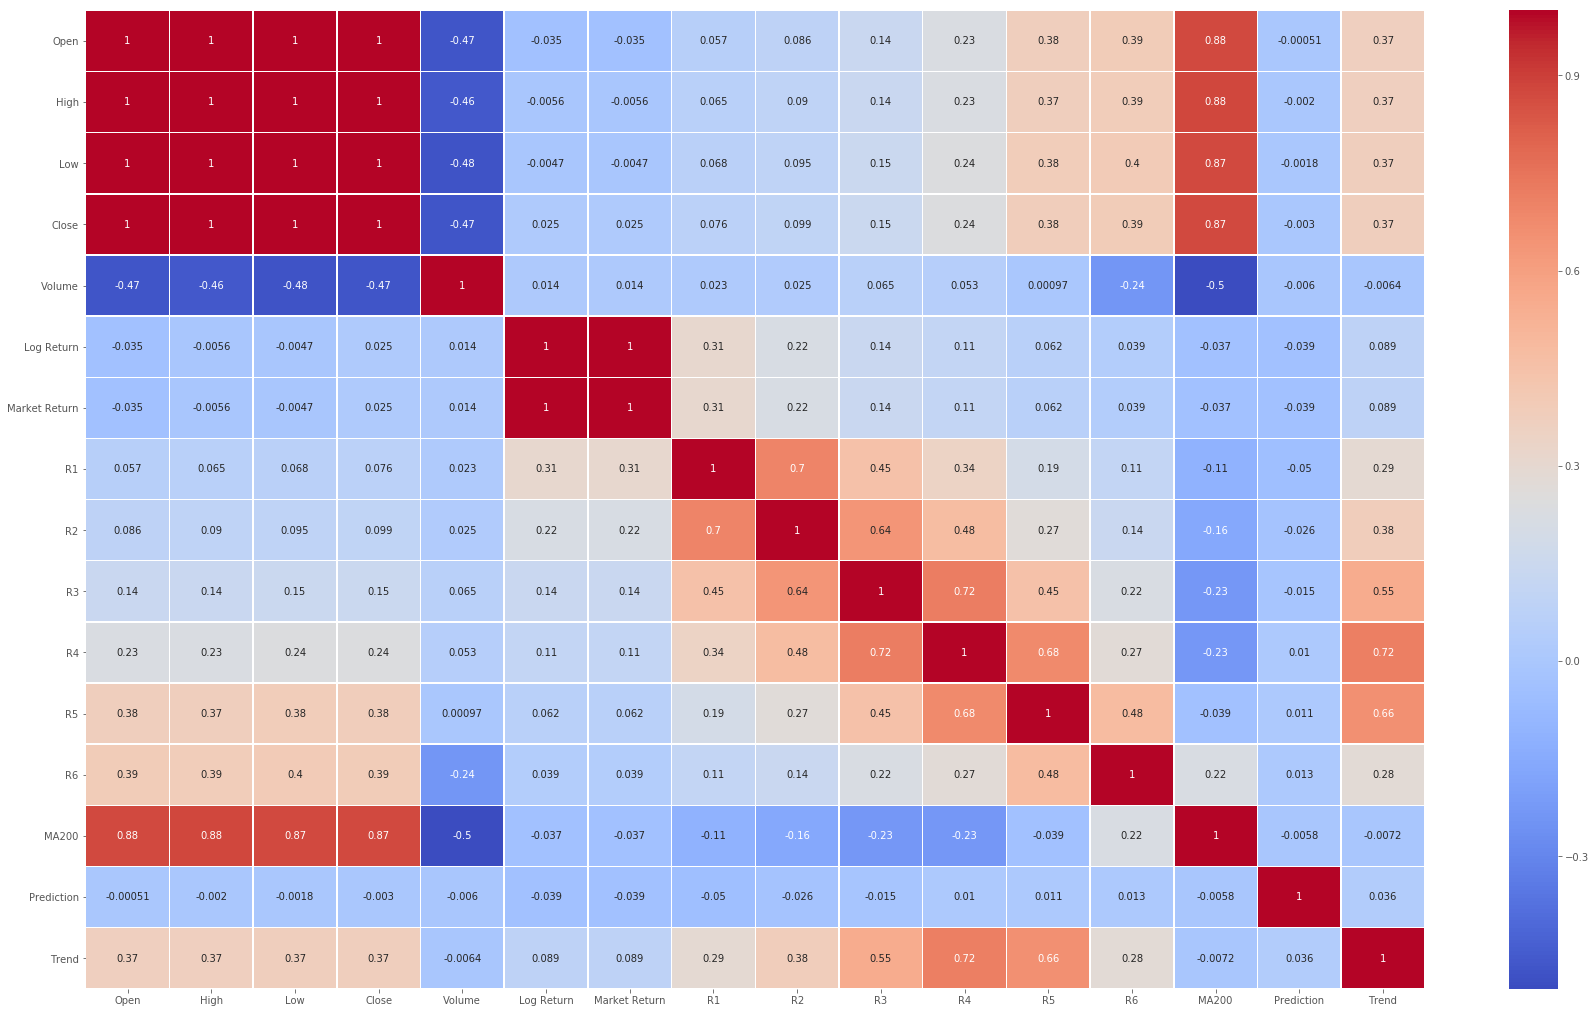

In [23]:
#Splitting the data
df_test = df3.loc['2020-01-01':'2020-02-28' ,:]  
df_train = df3.loc['2010-01-01':'2019-12-30',:] 

#Correlation map to help with feature selection
plt.figure(figsize = (30,18))
sns.heatmap(df_train.corr(),annot=True,linewidth = 0.5, cmap='coolwarm')
df_train.columns

In [24]:
# Select features and separate features and output

y_train = df_train['Prediction']
X_train = df_train.loc[:,[ 'Open', 'High', 'Low', 'Close', 'R1','R2', 'R3', 'R4', 'R5', 'R6', 
         'Trend'
                     ]]

y_test = df_test['Prediction']
X_test = df_test.loc[:,[  'Open', 'High', 'Low', 'Close','R1' , 'R2', 'R3', 'R4', 'R5', 'R6', 
         'Trend'
        ]]

#Normalizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [25]:
#Check the shapes and classes of our train and test sets

print(X_test.shape)
print(y_test.shape)

print('%% of Class0 : %f y_test' % (np.count_nonzero(y_test == 0)/float(len(y_test))))
print('%% of Class1 : %f y_test' % (np.count_nonzero(y_test == 1)/float(len(y_test))))

print(X_train.shape)
print(y_train.shape)

print('%% of Class0 : %f y_train' % (np.count_nonzero(y_train == 0)/float(len(y_train))))
print('%% of Class1 : %f y_train' % (np.count_nonzero(y_train == 1)/float(len(y_train))))

(42, 11)
(42,)
% of Class0 : 0.547619 y_test
% of Class1 : 0.452381 y_test
(2595, 11)
(2595,)
% of Class0 : 0.493642 y_train
% of Class1 : 0.506358 y_train


In [26]:
# Define Model and fit

clf = ensemble.GradientBoostingClassifier(verbose=3)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3835            0.49s
         2           1.3805            0.44s
         3           1.3784            0.45s
         4           1.3755            0.45s
         5           1.3728            0.45s
         6           1.3707            0.42s
         7           1.3685            0.41s
         8           1.3662            0.39s
         9           1.3628            0.40s
        10           1.3610            0.38s
        11           1.3596            0.39s
        12           1.3575            0.41s
        13           1.3542            0.39s
        14           1.3522            0.38s
        15           1.3507            0.37s
        16           1.3499            0.37s
        17           1.3480            0.37s
        18           1.3467            0.36s
        19           1.3452            0.35s
        20           1.3430            0.35s
        21           1.3412            0.35s
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=3, warm_start=False)

In [27]:
#Check our training accuracy
accuracy = clf.score(X_train, y_train)
print('Training Accuracy: %f' % accuracy)

Training Accuracy: 0.759152


In [28]:
#Make our predications

pred = clf.predict(X_test)

In [29]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)

print(cm)

[[15  8]
 [ 9 10]]


In [30]:
#Area under the curve
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5892448512585812

In [31]:
#Check actual accuracy of predictions
accuracy = clf.score(X_test, y_test)
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.595238


In [32]:
#Now lets add these predictions to our original unscaled data

#Import original unscaled dataset
df = pd.read_csv('CapstoneML.csv', parse_dates = True, index_col=0)

#Cut dataset to only represent January and February (this is what we have predicted)
df = df.iloc[12283:-45]

In [33]:
#Add our predictions to our dataset
df['Predlist'] = pred.tolist()

#Replace 0 with -1 to make it easier to calculate the returns for going short
df['Predlist']=df['Predlist'].replace({0:-1})

#Export and save changes to manually check
export_csv = df.to_csv (r'C:\Users\Seb Usai\Anaconda3\AAA WQU CF\Capstone\MLResults.csv', index = True, header=True)

Total Return = 0.0210461322831883
% of Time in Market = 100%
CAGR = 0.1262767936991298
Maximum Drawdown =  -0.013823828969856344


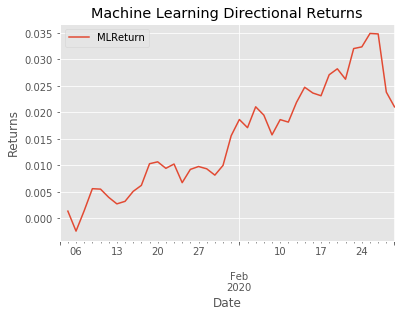

In [34]:
#Calculate performance metrics

df['MLReturn'] = df['Market Return']*df['Predlist'].shift(1)-0.0001#<this is the adjustment for trading costs
df['Index Return'] = (1 + df['MLReturn']).cumprod()
lookback = 1000
df['rolling_max'] = df['Index Return'].rolling(lookback, min_periods=1).max()
df['daily_drawdown'] = df['Index Return']/df['rolling_max'] - 1.0
df['max_daily_drawdown'] = df['daily_drawdown'].rolling(lookback, min_periods=1).min()
Return = df['MLReturn'].sum()
Number_of_Days = len(df.index)
CAGR = ((df['MLReturn'].sum())/Number_of_Days)*252


#Print and Plot

print("Total Return =",Return)
print("% of Time in Market = 100%")
print("CAGR =",CAGR)
print("Maximum Drawdown = ", df['max_daily_drawdown'].min())

#Plot the strategy returns
df['MLReturn'].cumsum().plot()
plt.title("Machine Learning Directional Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()


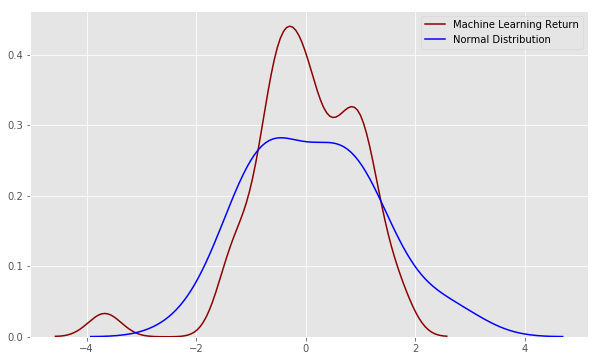

In [35]:
#Make a KDE plot to examine tails and density
returns = np.log(df['Index Return']).diff().dropna()
standard_return = (returns-returns.mean())/returns.std()

plt.figure(figsize=(10,6))
sns.kdeplot(standard_return, label="Machine Learning Return", bw=0.30, color='darkred')
sns.kdeplot(np.random.normal(size=len(df)), label="Normal Distribution", color = 'blue')

In [36]:
#Calculate Sharpe
dailysharpe = df['MLReturn'].mean()/df['MLReturn'].std()#Daily Sharpe Ratio
SharpeRatio = dailysharpe*(252**0.5)#Annualized Sharpe (daily sharpe by square root of number of trading days per year)
print("Sharpe Ratio = ", SharpeRatio)


#Calculate Sortino
target = 0
df['downside_returns'] = 0
df.loc[df['MLReturn'] < target, 'downside_returns'] = df['MLReturn']**2
expected_return = df['MLReturn'].mean()
down_stdev = np.sqrt(df['downside_returns'].mean())
sortino_ratio = (expected_return)/down_stdev
print("Sortino Ratio = ", sortino_ratio)

#Calculate Volatility
volatility = df['MLReturn'].std()
Annualised_Vol = volatility*(252**0.5)
print("Volatility = ",Annualised_Vol)

skew = skew(df['MLReturn'].dropna())
print("Skew",skew)

kurtosis = kurtosis(df['MLReturn'].dropna())
print("Kurtosis", kurtosis)

Sharpe Ratio =  2.6257866483872894
Sortino Ratio =  0.2437706386278514
Volatility =  0.04926398554738561


TypeError: 'float' object is not callable

In [37]:
df.sort_values('MLReturn',inplace=True, ascending=True)
VAR_95=df['MLReturn'].quantile(0.05)
VAR_99=df['MLReturn'].quantile(0.01)
VAR_999=df['MLReturn'].quantile(0.001)

print("VAR at 95% confidence level = ", VAR_95)
print("VAR at 99% confidence level = ", VAR_99)
print("VAR at 99.9% confidence level = ", VAR_999)

#Here we can say that we can be 99% certain losses will not exceed .68% in a 1 day timeframe although with such small sample size this is mostly irrelevant

#Note .0068 is 0.68% ie less than 1% - not 68%

VAR at 95% confidence level =  -0.003721325055570284
VAR at 99% confidence level =  -0.00809930039657205
VAR at 99.9% confidence level =  -0.010697791938937166
